# 08 · Neural Collaborative Filtering — Two-Tower Architecture

**two-tower** (dual-encoder) deep learning model:

```
  User ID  ──► Embedding ──► MLP ──► user_repr  ┐
                                                  ├─► dot ──► score
  Item ID  ──► Embedding ──► MLP ──► item_repr  ┘
  Genre features ──────────────┘
```

Training signal: **rating prediction** (MSE loss on explicit 0.5–5.0 ratings).
Evaluation: RMSE, MAE — comparable to notebooks 04–06.

**Requirements**
```
pip install torch
```

In [13]:
# Install PyTorch if needed (uncomment the line appropriate for your platform):
# CPU-only:  !pip install torch --index-url https://download.pytorch.org/whl/cpu
# CUDA 11.8: !pip install torch --index-url https://download.pytorch.org/whl/cu118

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'   # fix OpenMP conflict between torch and implicit

import pickle
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

ROOT   = Path.cwd().parents[1]
SRC    = ROOT / 'src'
FEAT   = SRC / 'data' / 'features'
PROC   = SRC / 'data' / 'processed'
MODELS = SRC / 'models'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED   = 42
torch.manual_seed(SEED)

print(f'Device: {DEVICE}')
print(f'PyTorch: {torch.__version__}')

Device: cuda
PyTorch: 2.10.0+cu126


## 1 · Load Data

In [15]:
ratings_df = pd.read_parquet(PROC / 'ratings_cleaned.parquet',
                              columns=['userId', 'movieId', 'rating', 'timestamp'])
movies_df  = pd.read_parquet(FEAT / 'movie_features.parquet')

with open(FEAT / 'id_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

user_id_map  = mappings['user_id_map']
movie_id_map = mappings['movie_id_map']
idx_to_movie = mappings['idx_to_movie']

n_users = len(user_id_map)
n_items = len(movie_id_map)
print(f'Users: {n_users:,}   Items: {n_items:,}   Ratings: {len(ratings_df):,}')

Users: 162,112   Items: 32,424   Ratings: 24,914,810


## 2 · Pre-compute Item Genre Features

Each item gets a fixed-size genre vector that is concatenated with its learned embedding inside the item tower.

In [16]:
genre_cols   = [c for c in movies_df.columns if c.startswith('genre_')]
n_genres     = len(genre_cols)
movies_idx   = movies_df.set_index('movieId')

# Build (n_items, n_genres) float32 array ordered by movie_idx
item_genre_feats = np.zeros((n_items, n_genres), dtype=np.float32)
for movie_id, midx in movie_id_map.items():
    if movie_id in movies_idx.index:
        item_genre_feats[midx] = movies_idx.loc[movie_id, genre_cols].values.astype(np.float32)

# Convert to a tensor kept on CPU (indexed during training per batch)
item_genre_tensor = torch.from_numpy(item_genre_feats)   # (n_items, n_genres)
print('Item genre feature matrix:', item_genre_tensor.shape)

Item genre feature matrix: torch.Size([32424, 20])


## 3 · Train / Test Split & Dataset

In [17]:
ratings_df = ratings_df.sort_values('timestamp').reset_index(drop=True)
split_idx  = int(len(ratings_df) * 0.8)
train_df   = ratings_df.iloc[:split_idx]
test_df    = ratings_df.iloc[split_idx:]

# Map IDs to 0-based indices
train_df = train_df.copy()
train_df['user_idx']  = train_df['userId'].map(user_id_map)
train_df['movie_idx'] = train_df['movieId'].map(movie_id_map)
train_df = train_df.dropna(subset=['user_idx', 'movie_idx'])

test_df = test_df.copy()
test_df['user_idx']  = test_df['userId'].map(user_id_map)
test_df['movie_idx'] = test_df['movieId'].map(movie_id_map)
test_df = test_df.dropna(subset=['user_idx', 'movie_idx'])

print(f'Train: {len(train_df):,}   Test: {len(test_df):,}')

Train: 19,931,848   Test: 4,982,962


In [18]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.user_idxs  = torch.tensor(df['user_idx'].values,  dtype=torch.long)
        self.movie_idxs = torch.tensor(df['movie_idx'].values, dtype=torch.long)
        self.ratings    = torch.tensor(df['rating'].values,    dtype=torch.float32)

    def __len__(self):  return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_idxs[idx], self.movie_idxs[idx], self.ratings[idx]


BATCH = 4096
train_loader = DataLoader(RatingsDataset(train_df), batch_size=BATCH,
                          shuffle=True,  num_workers=0, pin_memory=False)
test_loader  = DataLoader(RatingsDataset(test_df),  batch_size=BATCH * 4,
                          shuffle=False, num_workers=0, pin_memory=False)

print(f'Train batches: {len(train_loader):,}   Test batches: {len(test_loader):,}')

Train batches: 4,867   Test batches: 305


## 4 · Two-Tower Model

In [19]:
class TwoTowerNCF(nn.Module):
    """
    Two-tower neural collaborative filtering.

    User tower : user_emb(u)                    → MLP → u_repr
    Item tower : item_emb(i) || genre_feats(i)  → MLP → i_repr
    Score      : dot(u_repr, i_repr) + bias
    """

    def __init__(self, n_users, n_items, n_genres,
                 emb_dim=64, hidden_dim=128, out_dim=32, dropout=0.2,
                 global_mean=3.5):
        super().__init__()

        self.user_emb = nn.Embedding(n_users, emb_dim, sparse=False)
        self.item_emb = nn.Embedding(n_items, emb_dim, sparse=False)

        # Biases (scalar correction per user / item)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        # Initialise global bias to dataset mean so outputs start in-range
        self.global_bias = nn.Parameter(torch.tensor([global_mean]))

        # User MLP: emb_dim → hidden → out
        self.user_tower = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )

        # Item MLP: (emb_dim + n_genres) → hidden → out
        self.item_tower = nn.Sequential(
            nn.Linear(emb_dim + n_genres, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
        )

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids, genre_feats):
        # User tower
        u_emb  = self.user_emb(user_ids)                          # (B, emb_dim)
        u_repr = self.user_tower(u_emb)                           # (B, out_dim)

        # Item tower
        i_emb  = self.item_emb(item_ids)                          # (B, emb_dim)
        i_in   = torch.cat([i_emb, genre_feats], dim=-1)          # (B, emb+genres)
        i_repr = self.item_tower(i_in)                            # (B, out_dim)

        # Score = dot product + biases
        dot    = (u_repr * i_repr).sum(dim=-1)                    # (B,)
        score  = (dot
                  + self.user_bias(user_ids).squeeze(-1)
                  + self.item_bias(item_ids).squeeze(-1)
                  + self.global_bias)
        return score


# Compute dataset mean rating to initialise global bias
global_mean = ratings_df['rating'].mean()
print(f'Global mean rating: {global_mean:.4f}')

model = TwoTowerNCF(
    n_users=n_users, n_items=n_items, n_genres=n_genres,
    emb_dim=64, hidden_dim=128, out_dim=32,
    global_mean=float(global_mean),
).to(DEVICE)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model parameters: {n_params:,}')

Global mean rating: 3.5336
Model parameters: 12,672,297


## 5 · Training

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=2, factor=0.5
)

# Move genre matrix to device once
item_genre_tensor = item_genre_tensor.to(DEVICE)


def run_epoch(loader, train=True):
    model.train(train)
    total_loss, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for u_ids, i_ids, ratings in loader:
            u_ids   = u_ids.to(DEVICE)
            i_ids   = i_ids.to(DEVICE)
            ratings = ratings.to(DEVICE)
            genres  = item_genre_tensor[i_ids]     # (B, n_genres)

            preds = model(u_ids, i_ids, genres)
            # Loss on RAW outputs — clamping kills gradients for out-of-range values
            loss  = criterion(preds, ratings)

            if train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

            # RMSE metric uses clamped predictions (realistic range)
            preds_clamped = preds.detach().clamp(0.5, 5.0)
            total_loss += ((preds_clamped - ratings) ** 2).sum().item()
            n          += len(ratings)

    return (total_loss / n) ** 0.5   # RMSE


N_EPOCHS = 10   # increase to 20-30 for better results
best_val_rmse = float('inf')
history = []

print(f'Training for {N_EPOCHS} epochs on {DEVICE} …')
print(f'(Full dataset: ~{len(train_loader):,} batches × {BATCH} = {len(train_df):,} samples)')

for epoch in range(1, N_EPOCHS + 1):
    train_rmse = run_epoch(train_loader, train=True)
    val_rmse   = run_epoch(test_loader,  train=False)
    scheduler.step(val_rmse)
    history.append({'epoch': epoch, 'train_rmse': train_rmse, 'val_rmse': val_rmse})
    print(f'Epoch {epoch:2d}/{N_EPOCHS}  Train RMSE: {train_rmse:.4f}  Val RMSE: {val_rmse:.4f}')

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), MODELS / 'neural_cf_best.pt')

print(f'\nBest Val RMSE: {best_val_rmse:.4f}')

Training for 10 epochs on cuda …
(Full dataset: ~4,867 batches × 4096 = 19,931,848 samples)
Epoch  1/10  Train RMSE: 0.8545  Val RMSE: 0.9944
Epoch  2/10  Train RMSE: 0.8219  Val RMSE: 0.9949
Epoch  3/10  Train RMSE: 0.8065  Val RMSE: 0.9945
Epoch  4/10  Train RMSE: 0.7979  Val RMSE: 0.9935
Epoch  5/10  Train RMSE: 0.7921  Val RMSE: 0.9952
Epoch  6/10  Train RMSE: 0.7884  Val RMSE: 0.9956
Epoch  7/10  Train RMSE: 0.7856  Val RMSE: 0.9947
Epoch  8/10  Train RMSE: 0.7694  Val RMSE: 0.9978
Epoch  9/10  Train RMSE: 0.7658  Val RMSE: 0.9994
Epoch 10/10  Train RMSE: 0.7646  Val RMSE: 0.9982

Best Val RMSE: 0.9935


## 6 · Training Curve

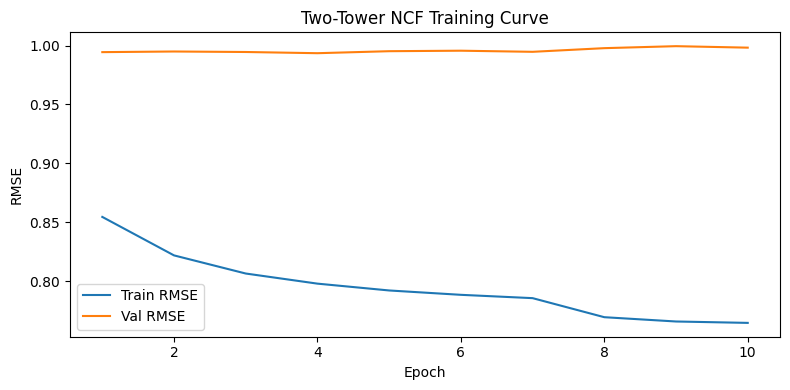

In [21]:
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(history)
plt.figure(figsize=(8, 4))
plt.plot(hist_df['epoch'], hist_df['train_rmse'], label='Train RMSE')
plt.plot(hist_df['epoch'], hist_df['val_rmse'],   label='Val RMSE')
plt.xlabel('Epoch'); plt.ylabel('RMSE')
plt.title('Two-Tower NCF Training Curve')
plt.legend(); plt.tight_layout(); plt.show()

## 7 · MAE Evaluation

In [22]:
# Load best checkpoint
model.load_state_dict(torch.load(MODELS / 'neural_cf_best.pt', map_location=DEVICE))
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for u_ids, i_ids, ratings in test_loader:
        u_ids   = u_ids.to(DEVICE)
        i_ids   = i_ids.to(DEVICE)
        genres  = item_genre_tensor[i_ids]
        preds   = model(u_ids, i_ids, genres).clamp(0.5, 5.0)
        all_preds.append(preds.cpu().numpy())
        all_true.append(ratings.numpy())

preds_np = np.concatenate(all_preds)
true_np  = np.concatenate(all_true)

rmse = np.sqrt(np.mean((preds_np - true_np) ** 2))
mae  = np.mean(np.abs(preds_np - true_np))
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE:  {mae:.4f}')

Test RMSE: 0.9935
Test MAE:  0.7608


## 8 · Sample Recommendations

In [23]:
@torch.no_grad()
def get_ncf_recs(user_id, n=10):
    """Top-n recommendations for a MovieLens user."""
    if user_id not in user_id_map:
        print(f'User {user_id} not in training data.')
        return pd.DataFrame()

    user_idx = user_id_map[user_id]
    seen_ids = set(train_df[train_df['userId'] == user_id]['movie_idx'].astype(int))

    model.eval()
    all_item_idxs = torch.arange(n_items, device=DEVICE)
    u_batch       = torch.full((n_items,), user_idx, dtype=torch.long, device=DEVICE)
    genres_all    = item_genre_tensor   # already on DEVICE

    scores = model(u_batch, all_item_idxs, genres_all).cpu().numpy()

    # Exclude seen items
    for sidx in seen_ids:
        if 0 <= sidx < len(scores):
            scores[sidx] = -np.inf

    top_idxs = np.argsort(scores)[::-1][:n]
    rows = []
    for midx in top_idxs:
        mid = idx_to_movie.get(int(midx))
        if mid and mid in movies_idx.index:
            r = movies_idx.loc[mid]
            rows.append({
                'title':      r['title'],
                'genres':     r['genres'],
                'year':       r.get('year'),
                'ncf_score':  round(float(scores[midx]), 3),
                'avg_rating': r.get('avg_rating'),
            })
    return pd.DataFrame(rows)


recs = get_ncf_recs(user_id=1, n=10)
print('Top 10 for user 1:')
recs

Top 10 for user 1:


,title,genres,year,ncf_score,avg_rating
0,"Godfather, The (1972)",Crime|Drama,1972.0,4.551,4.323588
1,"Shawshank Redemption, The (1994)",Crime|Drama,1994.0,4.519,4.412789
2,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0,4.505,4.283678
3,Schindler's List (1993),Drama|War,1993.0,4.445,4.246764
4,"Godfather: Part II, The (1974)",Crime|Drama,1974.0,4.430,4.260997
5,One Flew Over the Cuckoo's Nest (1975),Drama,1975.0,4.410,4.218182
6,Whiplash (2014),Drama,2014.0,4.381,4.135119
7,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller,2006.0,4.375,4.199695
8,American Beauty (1999),Drama|Romance,1999.0,4.368,4.106644
9,12 Angry Men (1957),Drama,1957.0,4.344,4.242191


## 9 · Save Model & Metadata

In [24]:
import yaml

# Save model config so we can rebuild the architecture at load time
model_config = {
    'n_users':    n_users,
    'n_items':    n_items,
    'n_genres':   n_genres,
    'emb_dim':    64,
    'hidden_dim': 128,
    'out_dim':    32,
    'genre_cols': genre_cols,
}
with open(MODELS / 'neural_cf_config.yaml', 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False)

results = {
    'model': 'TwoTower-NCF',
    'rmse':  float(round(rmse, 4)),
    'mae':   float(round(mae,  4)),
    'best_val_rmse': float(round(best_val_rmse, 4)),
    'n_epochs': N_EPOCHS,
}
with open(MODELS / 'neural_cf_results.yaml', 'w') as f:
    yaml.dump(results, f, default_flow_style=False)

print('Config  → src/models/neural_cf_config.yaml')
print('Weights → src/models/neural_cf_best.pt')
print('Results → src/models/neural_cf_results.yaml')
print(f'\nFinal — RMSE: {rmse:.4f}   MAE: {mae:.4f}')

Config  → src/models/neural_cf_config.yaml
Weights → src/models/neural_cf_best.pt
Results → src/models/neural_cf_results.yaml

Final — RMSE: 0.9935   MAE: 0.7608
